In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import json
from pprint import pprint
import numpy as np
Settings = json.load(open('settings.txt'))
pprint(Settings)
import numpy as np
import sys
sys.path.append('../')
from cabbage.regression.Regression import get_W_mot16_02_dmax100
from cabbage.MultiplePeopleTracking import GraphGenerator, BatchGraphGenerator
from cabbage.features.deepmatching import ReadOnlyDeepMatching
from cabbage.features.ReId import StoredReId, StackNet64x64, get_element
from experiments import MOT16_Experiments, remove_negative_pairs
from cabbage.data.video import VideoData
from cabbage.features.combined import AABBLookup, gen_feature_batch
from time import time
root = Settings['data_root']
print("\n")

reid = StackNet64x64(root)
dm = ReadOnlyDeepMatching(root, 100)  # deep matches are set-up for 100 frames

dmax = 30


mot16 = MOT16_Experiments(root)
video_name = 'MOT16-11'
X = mot16.mot16_11_X

#Dt = mot16.mot16_11_detections
Dt = mot16.mot16_11_true_detections_no_pid
vd = VideoData(Dt)
Dt = vd.get_n_first_frames(50)

W = get_W_mot16_02_dmax100(root)

print("\nDt", Dt.shape)
print("\n")


lookup = AABBLookup(Dt, X)

ALL_PAIRS = lookup.get_all_pairs(dmax)

#generator = BatchGraphGenerator(root, reid=reid, dm=dm, dmax=dmax, video_name=video_name)
#generator.build(Dt, X, W, batch_size=4)

{'data_root': '/home/data',
 'deepmatch': '/home/deepmatching_1.2.2_c++/deepmatching-static',
 'graph_solver': '/home/cabbage/build/sample'}


Using TensorFlow backend.




Found model /home/data/reid_models/stacknet64x64_84acc.h5! :)

Dt (267, 6)


ALL PAIRS: (30793, 2)
	elapsed seconds: 0.005522966384887695


In [2]:
batch = ALL_PAIRS[0:25]
dmax = 1

delta, edge_weights, i_, j_ = gen_feature_batch(
                batch, lookup, dmax, dm, reid, W, video_name)

print(edge_weights)
print(i_)

[ -7.92356517  -9.01800145 -11.86027977]
[0 0 0]


In [3]:
from cabbage.features.GenerateFeatureVector import pairwise_features

for loc in range(5):
    i = batch[loc,0]; j = batch[loc,1]

    aabb1, _, conf1, frame1 = lookup[i]
    aabb2, _, conf2, frame2 = lookup[j]

    delta = int(abs(frame2-frame1) )

    I1 = X[int(frame1-1)]
    I2 = X[int(frame2-1)]


    gen = pairwise_features(root,None,DM_object=dm, reid_object=reid)
    vec = gen.get_pairwise_vector(
                                video_name,
                                I1, I2,
                                frame1,frame2,
                                aabb1,aabb2,
                                conf1,conf2)

    cost = -1 * (W[delta]@np.array(vec))

    print(cost)

-7.92538767218
-9.90441418521
-11.9038817225
-5.88513015446
9.89341950731


/home/data/MOT16 found :)
MOT16: load memmapped file /home/data/MOT16/train/MOT16-11/data.memmap
MOT16 X loaded
MOT16 Y_det loaded
MOT16 Y_gt loaded

COST: 13.0007450391


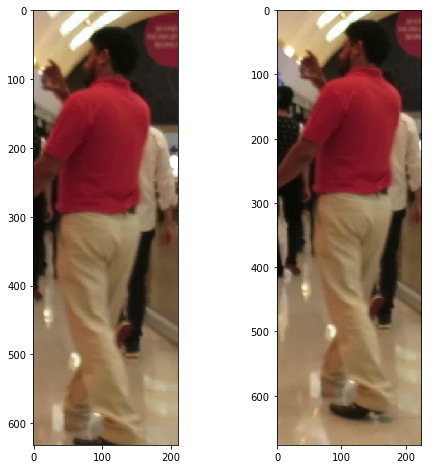

In [4]:
from pak.datasets.MOT import MOT16
mot16__ = MOT16(root)
ALL_DETECTIONS = mot16.mot16_11_true_detections_no_pid

X, Y_det, Y_gt = mot16__.get_train("MOT16-11", memmapped=True)

# ----- contenders:
idx1 = 2; idx2 = 16;

W = get_W_mot16_02_dmax100(root)
elem1 = ALL_DETECTIONS[idx1]; elem2 = ALL_DETECTIONS[idx2]
frame1 = int(elem1[0]); frame2 = int(elem2[0])
aabb1 = elem1[1:5]; aabb2 = elem2[1:5]
conf1 = elem1[5]; conf2 = elem2[5]
delta = int(abs(frame2-frame1) )

I1 = X[frame1-1]; I2 = X[frame2-1]

vec = gen.get_pairwise_vector(
                            video_name,
                            I1, I2,
                            frame1,frame2,
                            aabb1,aabb2,
                            conf1,conf2)


cost = -1 * (W[delta]@np.array(vec))

print('\n===================')
print("COST:", cost)
print('===================')

fig = plt.figure(figsize=(8,8))
x,y,w,h = aabb1.astype('int32')
fig.add_subplot(121).imshow(I1[y:y+h,x:x+w])
x,y,w,h = aabb2.astype('int32')
fig.add_subplot(122).imshow(I1[y:y+h,x:x+w])
plt.show()